In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pickle

def prepare_metrics_df(results_dict):
    # Flatten results_dict into a DataFrame
    flat = []
    for config, records in results_dict.items():
        for rec in records:
            flat.append({
                "config": rec["config"],
                "fold": rec["fold"],
                "split": rec["split"],
                "r2": rec["r2"],
                "rmse": rec["rmse"]
            })
    return pd.DataFrame(flat)

def plot_metrics(results_dict, output_path: str, sorted_configs=None):
    df_metrics = prepare_metrics_df(results_dict)
    if sorted_configs is None:
        sorted_configs = sorted(df_metrics["config"].unique(), key=lambda x: x.lower())
    df_metrics["config"] = pd.Categorical(df_metrics["config"], categories=sorted_configs, ordered=True)
    
    # Enhanced color palette for professional look
    main_colors = ['#2E86AB', '#A23B72', '#F18F01', '#50C878', '#9966CC'][:len(sorted_configs)]
    main_palette = dict(zip(sorted_configs, main_colors))
    
    # Set professional theme
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'serif',
        'axes.linewidth': 1.2,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'grid.alpha': 0.3,
        'grid.linewidth': 0.8,
        'figure.facecolor': 'white'
    })
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)

    for ax, metric in zip(axes, ["r2", "rmse"]):
        df_group = df_metrics[df_metrics["split"] == "groupkfold"]
        df_kfold = df_metrics[df_metrics["split"] == "kfold"]

        # Main boxplot: groupkfold with enhanced styling
        sns.boxplot(
            x="config", y=metric, data=df_group, ax=ax,
            palette=main_colors, width=0.6, showfliers=False,
            boxprops=dict(alpha=0.8, linewidth=1.5),
            medianprops=dict(color='#4B352A', linewidth=1),
            whiskerprops=dict(linewidth=1.5),
            capprops=dict(linewidth=1.5),
        )
        
        # Overlay: kfold (subtle grey)
        sns.boxplot(
            x="config", y=metric, data=df_kfold, ax=ax,
            palette=["#D3D3D3"] * len(sorted_configs),
            width=0.6, linewidth=1.0, showfliers=False,
            boxprops=dict(alpha=0.5, linewidth=1.5),
            medianprops=dict(color='#4B352A', linewidth=1),
            whiskerprops=dict(color='#808080', linewidth=1.5),
            capprops=dict(color='#808080', linewidth=1.5),
        )

        # Stripplots
        sns.stripplot(
            x="config", y=metric, data=df_group, ax=ax,
            palette=main_colors, size=4, jitter=0.3, 
            edgecolor='white', linewidth=0.8, alpha=0.85
        )
        sns.stripplot(
            x="config", y=metric, data=df_kfold, ax=ax,
            color='#A0A0A0', size=4, jitter=0.3, 
            edgecolor='white', linewidth=0.8, alpha=0.6
        )

        # Axis formatting
        ax.set_xlabel("Model", fontsize=14, fontweight='bold', labelpad=10)
        ax.set_ylabel("R²" if metric == "r2" else "RMSE", fontsize=14, fontweight='bold', labelpad=10)
        ax.tick_params(axis='x', rotation=0, labelsize=12, pad=5)
        ax.tick_params(axis='y', labelsize=11)
        ax.grid(axis='y', linestyle='--', linewidth=0.8, color='gray', alpha=0.4)
        ax.set_axisbelow(True)

    plt.tight_layout()
    fig.savefig(output_path, bbox_inches="tight", dpi=600, facecolor='white')
    plt.show()

In [9]:
import pickle
import json
results_dict_path = "/home/msp/saleh/KinForm/results/unikp_comp_km.pkl"
with open(results_dict_path, "rb") as f:
    results_dict = pickle.load(f)
# results_dict = {k: v for k, v in results_dict.items() if k != "KINEFORM-L"}
# # rename KINEFORM-H to KINEFORM
# results_dict["KINEFORM"] = results_dict.pop("KINEFORM-H")
# new_list = []
# for rec in results_dict["KINEFORM"]:
#     assert rec["config"] == "KINEFORM-H"
#     rec["config"] = "KINEFORM"
#     new_list.append(rec)
# results_dict["KINEFORM"] = new_list

/tmp/ipykernel_3963024/1445872659.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_3963024/1445872659.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_3963024/1445872659.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/tmp/ipykernel_3963024/1445872659.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_3963024/1445872659.py:61: F

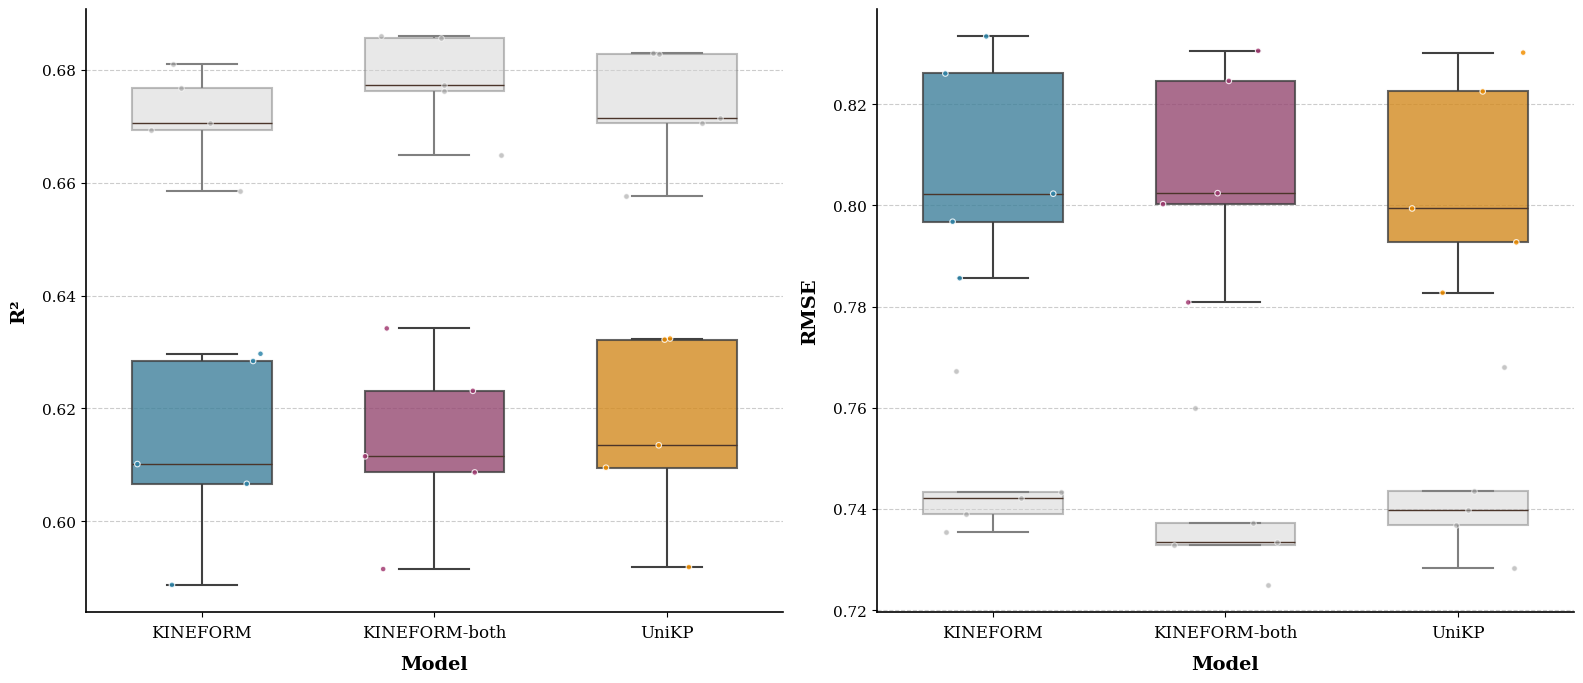

In [10]:
plot_metrics(results_dict, "/home/msp/saleh/KinForm/results/plots/km_unikp_comp.png")

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

def plot_true_vs_pred(results_dict, output_path: str):
    # Collect all entries into flat df
    rows = []
    for config, records in results_dict.items():
        for rec in records:
            for y_t, y_p in zip(rec["y_true"], rec["y_pred"]):
                rows.append({
                    "config": rec["config"],
                    "split": rec["split"],
                    "y_true": y_t,
                    "y_pred": y_p
                })
    df_all = pd.DataFrame(rows)
    
    configs = ["KINEFORM-H", "UniKP"]
    splits = ["groupkfold", "kfold"]

    fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True, sharey=True, constrained_layout=True)
    sns.set_theme(style="whitegrid", font_scale=1.3)

    for i, split in enumerate(splits):
        for j, config in enumerate(configs):
            ax = axes[i, j]
            df_plot = df_all[(df_all["config"] == config) & (df_all["split"] == split)]
            
            # Plot scatter
            sns.scatterplot(
                data=df_plot, x="y_true", y="y_pred", ax=ax,
                alpha=0.6, edgecolor="black", linewidth=0.4, s=40
            )
            # Identity line
            min_val, max_val = df_plot[["y_true", "y_pred"]].min().min(), df_plot[["y_true", "y_pred"]].max().max()
            ax.plot([min_val, max_val], [min_val, max_val], ls='--', color='gray', lw=1)

            # Pearson correlation
            pcc = pearsonr(df_plot["y_true"], df_plot["y_pred"])[0]
            ax.text(0.05, 0.92, f"PCC = {pcc:.3f}", transform=ax.transAxes,
                    fontsize=13, bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='gray'))

            ax.set_title(f"{config} ({split})", fontsize=14)
            ax.set_xlabel("True log(km/Km)" if i == 1 else "")
            ax.set_ylabel("Predicted" if j == 0 else "")

    # --- Compute fold sizes per split ---
    fold_counts = {}
    for split in ["groupkfold", "kfold"]:
        fold_sizes = []
        for config in configs:  # get first config as reference
            fold_sizes = [
                len(r["y_true"])
                for r in results_dict[config]
                if r["split"] == split
            ]
            break  # use only the first config (folds are shared across configs)
        fold_counts[split] = fold_sizes

    # --- Build caption text ---
    caption_lines = []
    for split in ["groupkfold", "kfold"]:
        counts = fold_counts[split]
        caption_lines.append(f"{split}: n = [{', '.join(str(n) for n in counts)}]")

    caption_text = "\n".join(caption_lines)

    # Add text below figure
    fig.text(0.5, -0.02, caption_text, ha='center', va='center', fontsize=12)

    # Save & show
    fig.savefig(output_path, bbox_inches="tight", dpi=600)
    plt.show()

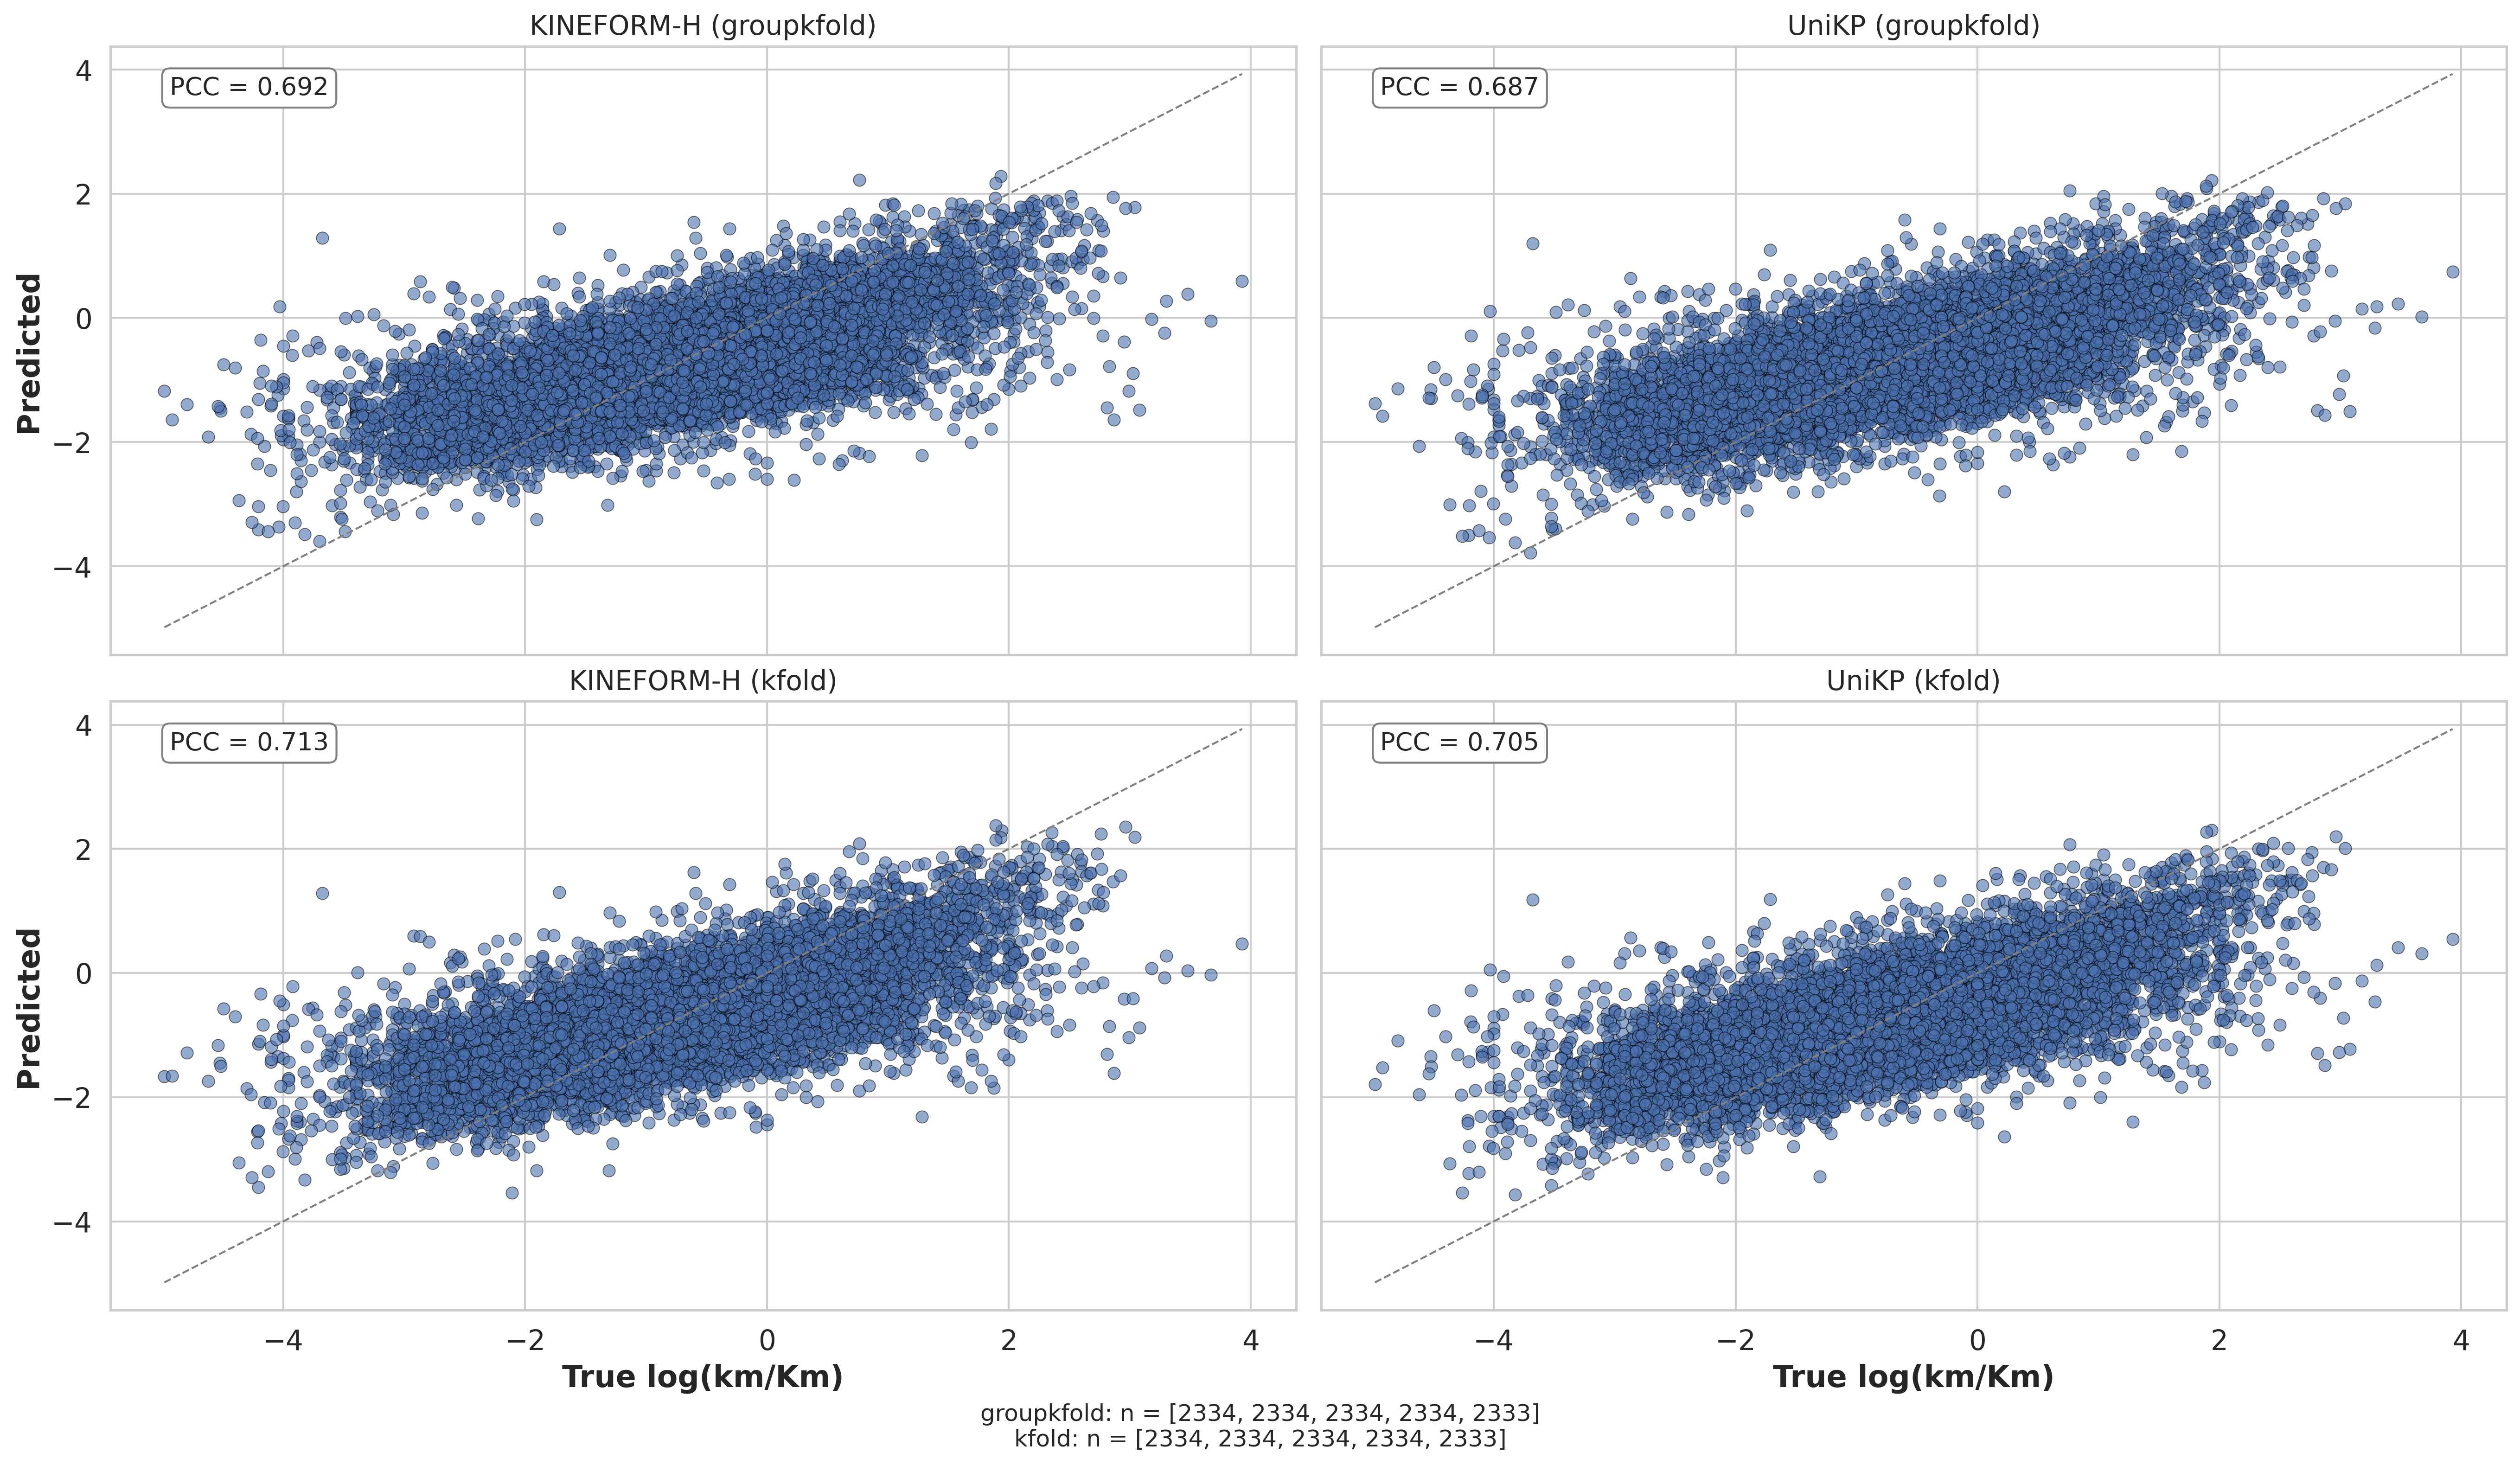

In [11]:
plot_true_vs_pred(results_dict, "/home/msp/saleh/KinForm/results/km_true_vs_pred_scatter.png")
